In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.4.1
[]


In [3]:
# Check with exported model and if it is well trained
# these codes are from inference_from_saved_model_tf2_colab.ipynb

import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

%matplotlib inline

In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
#   print(im_width, im_height)
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [5]:
# Path to label map file
PATH_TO_LABELS = os.path.join('/home001/yousung.choi/projects/project_coordination/workspace/training_demo/annotations','label_map.pbtxt')

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# 1: {'id': 1, 'name': 'book'},
print(category_index)

{1: {'id': 1, 'name': 'Cursor'}}


In [6]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/home001/yousung.choi/projects/project_coordination/workspace/training_demo/exported-models/3rd_trial_210323/saved_model')
# detect_fn = tf.saved_model.load('/home001/yousung.choi/projects/project_coordination/workspace/training_demo/exported-models/1st_trial/saved_model')
# detect_fn = tf.saved_model.load('/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/2nd_tria_320320/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 9.470087051391602s


In [7]:
# print(detect_fn.signatures['serving_default'].inputs)
# print(detect_fn.signatures['serving_default'].inputs)
print(detect_fn.signatures['serving_default'].output_dtypes)
# print(detect_fn.signatures['serving_default'].output_shapes)

{'detection_boxes': tf.float32, 'num_detections': tf.float32, 'raw_detection_boxes': tf.float32, 'detection_scores': tf.float32, 'detection_classes': tf.float32, 'detection_anchor_indices': tf.float32, 'raw_detection_scores': tf.float32, 'detection_multiclass_scores': tf.float32}


## 여러 가지 타입의 추론 타입들을 만들어 봄
### 1) Input : 사진 한장 / Output : 추론사진 한장
### 2) Input : 사진 여러장 / Output : 동영상 하나
### 3) Input : 동영상 하나 / Output : 동영상 하나
### 4) Input : 동영상 하나 / Output : 동영상 하나 및 좌표 정보 Array

[ True False False False False]
[0.6709869  0.0184361  0.01776621 0.01566774 0.01532304]
(640, 640, 3)
[0.8970849  0.9062931  0.92507225 0.9708305 ]
[1312, 676]
Elapsed time: 0.17608189582824707 second per image
dict_keys(['num_detections', 'detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'detection_classes', 'detection_scores', 'raw_detection_boxes'])


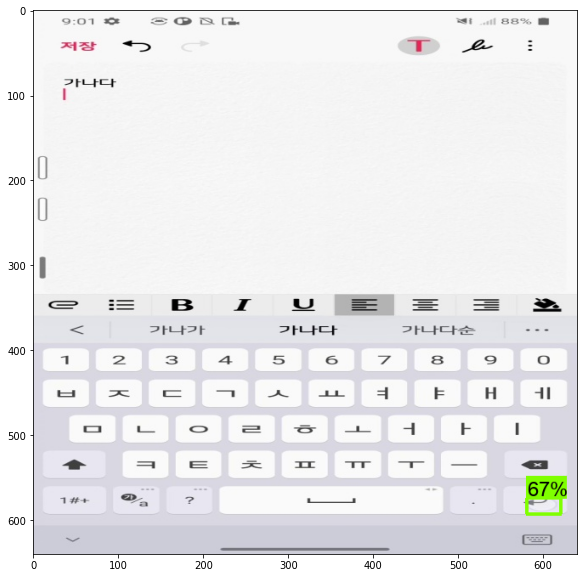

In [18]:
# 특정 파일 명 기반 사진 한장 추론

import os
import random
import cv2

# file_path = '/home001/yousung.choi/projects/project_coordination/workspace/training_demo/images/inference_original_image'
# file_path = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/2_video_to_imgs/Rainbow_Test/1_calculator/'
file_path = "/home001/yousung.choi/projects/project_coordination/tools/2_preprocessing_test/Rainbow_Test/13_Qmemo_typing_and_drawing/"
file_names = os.listdir(file_path)

elapsed = []
random.shuffle(file_names)
for i, file in enumerate(file_names):
    if file == 'images13425_resized_linear_0414.jpg':
      image_path = os.path.join(file_path, file)
      image_cv2 = cv2.imread(image_path, cv2.IMREAD_COLOR)
      image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
#       image_np = load_image_into_numpy_array(image_path)
      input_tensor = np.expand_dims(image_np, 0)
      start_time = time.time()
      detections = detect_fn(input_tensor)
      end_time = time.time()
      elapsed.append(end_time - start_time)

      plt.rcParams['figure.figsize'] = [10, 10]
      label_id_offset = 1
      image_np_with_detections = image_np.copy()
      viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            detections['detection_classes'][0].numpy().astype(np.int32),
            detections['detection_scores'][0].numpy(),
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.50,
            agnostic_mode=False, skip_labels = True)
    #   if i == 0 :
    #         print(detections['detection_boxes'][0].numpy(), detections['detection_boxes'][0].shape)
    #         print(detections['detection_scores'][0].numpy())
#       plt.subplot(len(file_names), 1b, i+1)
      print(detections['detection_scores'][0].numpy() > 0.6)
      print(detections['detection_scores'][0].numpy())
      print(image_np.shape)
      print(detections['detection_boxes'][0].numpy()[0])
      coordinates_y = [detections['detection_boxes'][0].numpy()[0][0], detections['detection_boxes'][0].numpy()[0][2]]
      coordinates_x = [detections['detection_boxes'][0].numpy()[0][1], detections['detection_boxes'][0].numpy()[0][3]]
      coordinates_y *= 1440
      coordinates_x *= 720
      final_coordinates = [round(sum(coordinates_y)/2), round(sum(coordinates_x)/2)]
      print(final_coordinates)
      plt.imshow(image_np_with_detections)



mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print(detections.keys())


In [12]:
print(detections['num_detections'][0].numpy())

5.0


In [ ]:
# 읽은 이미지들을 일괄 추론 후 mp4로 변환해서 저장해보자

import os
import random
import cv2
from tqdm import tqdm

file_path = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_original_image'
file_names = os.listdir(file_path)

elapsed = []
obj_cnted_more = []
obj_not_cnted = []
obj_cnt = 0
total_obj_cnt = 0

# setting for Video output
video_output = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_original_image/output_1st_720x1440_320320_model.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 10.0, (720, 1440))
# random.shuffle(file_names)
file_names.sort()
for i, file in enumerate(tqdm(file_names)):
    if file.endswith('jpg'):
        image_path = os.path.join(file_path, file)
        image_cv2 = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
        input_tensor = np.expand_dims(image_np, 0)

        start_time = time.time()
        detections = detect_fn(input_tensor)
        end_time = time.time()
        elapsed.append(end_time - start_time)

        plt.rcParams['figure.figsize'] = [10, 10]
        label_id_offset = 1
        image_np_with_detections = image_cv2.copy()
        viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'][0].numpy(),
              detections['detection_classes'][0].numpy().astype(np.int32),
              detections['detection_scores'][0].numpy(),
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=200,
              min_score_thresh=.60,
              agnostic_mode=False)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.6)[0])
        total_obj_cnt += obj_cnt
    
        if obj_cnt == 0 :
            obj_not_cnted.append(file)
#             print('No Count!!')
        elif obj_cnt > 1:
            obj_cnted_more.append(file)
#             print('Count more then 2!!')
            
        cv2.putText(image_np_with_detections, 'Counted {0:1d}'.format(total_obj_cnt), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
        cv2.putText(image_np_with_detections, 'noCount {0:1d}'.format(len(obj_not_cnted)), (180,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
        cv2.putText(image_np_with_detections, 'Dbl Cnt {0:1d}'.format(len(obj_cnted_more)), (20,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
        
        if i == len(file_names)-5:
            print(image_np_with_detections.shape)
            plt.imshow(image_np_with_detections)
#         elif i == 1001:
#             break

        out.write(image_np_with_detections)
        
out.release()

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print('Total obj_cnt : ', total_obj_cnt)
print('obj_not_cnted : ', len(obj_not_cnted))
print(obj_not_cnted)
print('obj_cnt_more : ', len(obj_cnted_more))
print(obj_cnted_more)


# print(detections.keys())

In [12]:
# 읽은 동영상을 일괄 추론해서 MP4 로 저장하기

import os
import random
import cv2
from tqdm import tqdm

elapsed = []
obj_cnted_more = []
obj_not_cnted = []
obj_cnted = []
obj_cnt = 0
total_obj_cnt = 0
# setting for Video input
# video_input = '/home001/yousung.choi/projects/project_coordination/workspace/training_demo/images/inference_video/Recording_2021-01-28-15-37-55_V50.mp4'
video_input = '/home001/yousung.choi/projects/project_coordination/tools/99_inferencing_test/1_Original_Video/9004_setting_alarm_V60.mp4'
video_handle = cv2.VideoCapture(video_input)

# setting for Video output
video_output = '/home001/yousung.choi/projects/project_coordination/tools/99_inferencing_test/2_inferenced_video/9004_setting_alarm_V60_inferenced.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 20.0, (720, 1640))

total_frm = np.arange(int(video_handle.get(cv2.CAP_PROP_FRAME_COUNT)))
# print(total_frm)

for frm_cnt in tqdm(total_frm):
    if out.isOpened():
        ret, image_cv2 = video_handle.read()
        if ret:
            image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
            input_tensor = np.expand_dims(image_np, 0)

            start_time = time.time()
            detections = detect_fn(input_tensor)
            end_time = time.time()
            elapsed.append(end_time - start_time)

            plt.rcParams['figure.figsize'] = [20, 20]
            label_id_offset = 1
            image_np_with_detections = image_cv2.copy()
            viz_utils.visualize_boxes_and_labels_on_image_array(
                  image_np_with_detections,
                  detections['detection_boxes'][0].numpy(),
                  detections['detection_classes'][0].numpy().astype(np.int32),
                  detections['detection_scores'][0].numpy(),
                  category_index,
                  use_normalized_coordinates=True,
                  max_boxes_to_draw=200,
                  min_score_thresh=.80,
                  agnostic_mode=False)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.9)[0])
            total_obj_cnt += obj_cnt
    
            if obj_cnt == 0 :
                obj_not_cnted.append(frm_cnt)
#                 cv2.imwrite('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/wrong_cnted_images/' + 'noobj_images{0:04d}.jpg'.format(frm_cnt), image_np_with_detections)
#                 print('No Count!!')
            elif obj_cnt > 1:
                obj_cnted_more.append(frm_cnt)
#                 cv2.imwrite('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/wrong_cnted_images/' + 'dbl_images{0:04d}.jpg'.format(frm_cnt), image_np_with_detections)
#                 print('Count more then 2!!')
            elif obj_cnt == 1:
                obj_cnted.append(frm_cnt)

            cv2.putText(image_np_with_detections, 'Frames {0:1d}'.format(frm_cnt+1), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Counted {0:1d}'.format(len(obj_cnted)), (180,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'noCount {0:1d}'.format(len(obj_not_cnted)), (20,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Dbl Cnt {0:1d}'.format(len(obj_cnted_more)), (180,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)

            out.write(image_np_with_detections)
        
out.release()

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print('Total frm cnt : ', frm_cnt)
print('obj_cnted : ', len(obj_cnted))
# print(obj_cnted)
print('obj_not_cnted : ', len(obj_not_cnted))
print(obj_not_cnted)
print('obj_cnt_more : ', len(obj_cnted_more))
print(obj_cnted_more)



100%|██████████| 542/542 [01:33<00:00,  5.77it/s]

Elapsed time: 0.12775574091175826 second per image
Total frm cnt :  541
obj_cnted :  146
obj_not_cnted :  395
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 

In [20]:
# 읽은 동영상을 일괄 추론해서 MP4 로 저장하기 - 해상도가 맞지 않아 Test용도로 자르기 시전.

import os
import random
import cv2
from tqdm import tqdm

elapsed = []
obj_cnted_more = []
obj_not_cnted = []
obj_cnted = []
obj_cnt = 0
total_obj_cnt = 0
# setting for Video input
# video_input = '/home001/yousung.choi/projects/project_coordination/workspace/training_demo/images/inference_video/Recording_2021-01-28-15-37-55_V50.mp4'
video_input = '/home001/yousung.choi/projects/project_coordination/tools/99_inferencing_test/1_Original_Video/1_210322_RainBow_Calculator/calculator_test.mp4'
video_handle = cv2.VideoCapture(video_input)

# setting for Video output
video_output = '/home001/yousung.choi/projects/project_coordination/tools/99_inferencing_test/1_Original_Video/1_210322_RainBow_Calculator/calculator_test_output_test.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 20.0, (720, 1440)) # changed from 1600

total_frm = np.arange(int(video_handle.get(cv2.CAP_PROP_FRAME_COUNT)))
# print(total_frm)

for frm_cnt in tqdm(total_frm):
    if out.isOpened():
        ret, image_cv2 = video_handle.read()
        if ret:
            image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
            input_tensor = np.expand_dims(image_np[:image_np.shape[1] * 2,:,:], 0)
#             print(image_cv2.shape)
#             if ret:
#                 break

            start_time = time.time()
            detections = detect_fn(input_tensor)
            end_time = time.time()
            elapsed.append(end_time - start_time)

            plt.rcParams['figure.figsize'] = [20, 20]
            label_id_offset = 1
            image_np_with_detections = image_cv2[:image_np.shape[1]*2,:,:].copy()
            viz_utils.visualize_boxes_and_labels_on_image_array(
                  image_np_with_detections,
                  detections['detection_boxes'][0].numpy(),
                  detections['detection_classes'][0].numpy().astype(np.int32),
                  detections['detection_scores'][0].numpy(),
                  category_index,
                  use_normalized_coordinates=True,
                  max_boxes_to_draw=200,
                  min_score_thresh=.90,
                  agnostic_mode=False)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.9)[0])
            total_obj_cnt += obj_cnt
    
            if obj_cnt == 0 :
                obj_not_cnted.append(frm_cnt)
#                 cv2.imwrite('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/wrong_cnted_images/' + 'noobj_images{0:04d}.jpg'.format(frm_cnt), image_np_with_detections)
#                 print('No Count!!')
            elif obj_cnt > 1:
                obj_cnted_more.append(frm_cnt)
#                 cv2.imwrite('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/wrong_cnted_images/' + 'dbl_images{0:04d}.jpg'.format(frm_cnt), image_np_with_detections)
#                 print('Count more then 2!!')
            elif obj_cnt == 1:
                obj_cnted.append(frm_cnt)

            cv2.putText(image_np_with_detections, 'Frames {0:1d}'.format(frm_cnt+1), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Counted {0:1d}'.format(len(obj_cnted)), (180,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'noCount {0:1d}'.format(len(obj_not_cnted)), (20,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Dbl Cnt {0:1d}'.format(len(obj_cnted_more)), (180,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)

            out.write(image_np_with_detections)
        
out.release()

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print('Total frm cnt : ', frm_cnt)
print('obj_cnted : ', len(obj_cnted))
# print(obj_cnted)
print('obj_not_cnted : ', len(obj_not_cnted))
print(obj_not_cnted)
print('obj_cnt_more : ', len(obj_cnted_more))
print(obj_cnted_more)



100%|██████████| 1452/1452 [04:36<00:00,  5.24it/s]

Elapsed time: 0.14590375646743564 second per image
Total frm cnt :  1451
obj_cnted :  364
obj_not_cnted :  1085
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 38, 39, 40, 41, 42, 43, 45, 51, 54, 55, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 22

In [14]:
print(detections.keys())

dict_keys(['detection_multiclass_scores', 'detection_classes', 'raw_detection_boxes', 'num_detections', 'raw_detection_scores', 'detection_anchor_indices', 'detection_boxes', 'detection_scores'])


In [16]:
print(detections['num_detections'])
print(detections['detection_boxes'])

tf.Tensor([5.], shape=(1,), dtype=float32)
tf.Tensor(
[[[0.9757161  0.86788505 0.99779856 0.93956095]
  [0.14133212 0.4023655  0.9117811  0.8947719 ]
  [0.03296813 0.01859522 0.96975684 1.        ]
  [0.00290743 0.9852119  0.01682646 0.99697477]
  [0.         0.         0.00793597 0.02868322]]], shape=(1, 5, 4), dtype=float32)


In [8]:
# 읽은 동영상을 일괄 추론해서 좌표만 표시되는 MP4 로 기존과 같이 저장 + 좌표값을 array로 살려내기

import os
import random
import cv2
from tqdm import tqdm

# variables for time check
elapsed = []

# variables for counting objects
obj_cnted_more = []
obj_not_cnted = []
obj_cnted = []
obj_cnt = 0
total_obj_cnt = 0

# setting for Video input
# video_input = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_201228.mp4'
# video_input = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_210119_3_Final_Demo.mp4'
video_input = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_201222.mp4'
video_handle = cv2.VideoCapture(video_input)

# setting for Video output
video_output = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_201217_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 30.0, (720, 1440))

# check # of input video total frames
total_frm = np.arange(int(video_handle.get(cv2.CAP_PROP_FRAME_COUNT)))

# variables for coordination records
coords_record = []

for frm_cnt in tqdm(total_frm):
    if out.isOpened():
        ret, image_cv2 = video_handle.read()
        if ret:
            image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
            input_tensor = np.expand_dims(image_np, 0)

            start_time = time.time()
            detections = detect_fn(input_tensor)
            end_time = time.time()
            elapsed.append(end_time - start_time)

            plt.rcParams['figure.figsize'] = [20, 20]
            label_id_offset = 1
            image_np_with_detections = image_cv2.copy()
            viz_utils.visualize_boxes_and_labels_on_image_array(
                  image_np_with_detections,
                  detections['detection_boxes'][0].numpy(),
                  detections['detection_classes'][0].numpy().astype(np.int32),
                  detections['detection_scores'][0].numpy(),
                  category_index,
                  use_normalized_coordinates=True,
                  max_boxes_to_draw=200,
                  min_score_thresh=.90,
                  agnostic_mode=False)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.9)[0])
            total_obj_cnt += obj_cnt
    
            coordinates_y = [detections['detection_boxes'][0].numpy()[0][0], detections['detection_boxes'][0].numpy()[0][2]] * 1440
            coordinates_x = [detections['detection_boxes'][0].numpy()[0][1], detections['detection_boxes'][0].numpy()[0][3]] * 720
            final_coord = [round(sum(coordinates_y)/2), round(sum(coordinates_x)/2)]
            final_coord = list(map(int, final_coord))
            if obj_cnt == 1:
                coords_record.append(final_coord)
                obj_cnted.append(frm_cnt)
            elif obj_cnt > 1:
                coords_record.append([-2,-2])
                obj_cnted_more.append(frm_cnt)
            else : #obj_cnt == 0
                coords_record.append([-1,-1])
                obj_not_cnted.append(frm_cnt)
            
#             coordination_img = np.ones((1440, 720, 3))
#             coordination_img[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440),max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 0:2] = 0
#             coordination_img[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440),max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 2] = 255

            cv2.putText(image_np_with_detections, 'Frames {0:1d}'.format(frm_cnt+1), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Counted {0:1d}'.format(len(obj_cnted)), (180,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'noCount {0:1d}'.format(len(obj_not_cnted)), (20,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Dbl Cnt {0:1d}'.format(len(obj_cnted_more)), (180,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            
            # Just for test
            if obj_cnt == 1:
                image_np_with_detections[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440), max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 0:2] = 0
                image_np_with_detections[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440), max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 2] = 255
            
#             if frm_cnt == 0:
# #                 print(image_np_with_detections)
# #                 print(image_np_with_detections.max())
#                 image_np_with_detections = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)
#                 plt.imshow(image_np_with_detections)
#                 break
            
#             out.write(image_np_with_detections)
        
# out.release()

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image / ' + str(sum(elapsed)) + ' for total')
print('Total frm cnt : ', frm_cnt + 1)
print('obj_cnted : ', len(obj_cnted))
# print(obj_cnted)
print('obj_not_cnted : ', len(obj_not_cnted))
# print(obj_not_cnted)
print('obj_cnt_more : ', len(obj_cnted_more))
# print(obj_cnted_more)

# print(coords_record)


100%|██████████| 604/604 [00:13<00:00, 43.70it/s]

Elapsed time: 0.014234482057836671 second per image / 8.59762716293335 for total
Total frm cnt :  604
obj_cnted :  438
obj_not_cnted :  157
obj_cnt_more :  9


In [10]:
np_coords = np.array(coords_record)
print(np_coords.shape)
print(np_coords)

(604, 2)
[[-1 -1]
 [-1 -1]
 [-1 -1]
 ...
 [-1 -1]
 [-1 -1]
 [-1 -1]]


In [54]:
for i, j in np_coords:
        print(i, j)

1113 192
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
1085 420
-2 -2
-2 -2
1085 458
1087 471
1086 484
1086 496
1087 508
1086 520
1087 531
1087 542
1086 552
1085 563
1085 572
1084 583
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
1087 527
1083 508
1082 490
1081 471
1078 452
1076 433
1075 414
1074 395
1074 375
-2 -2
-2 -2
-2 -2
1076 295
-2 -2
-2 -2
1077 242
1077 228
1077 215
1080 204
1081 193
1082 184
1083 176
1084 172
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
1072 487
1073 502
1073 516
1073 531
1073 546
1072 559
1072 568
1071 576
1071 582
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
1069 593
1069 593
1069 594
1075 487
1076 461
1078 435
1078 410
1079 383
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
-2 -2
1

In [55]:
with open('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/np_array.txt', 'w') as f:
    for i, j in np_coords:
        data = [str(i), str(j)]
        f.write(str(data) + '\n')

(604, 2)
438
166


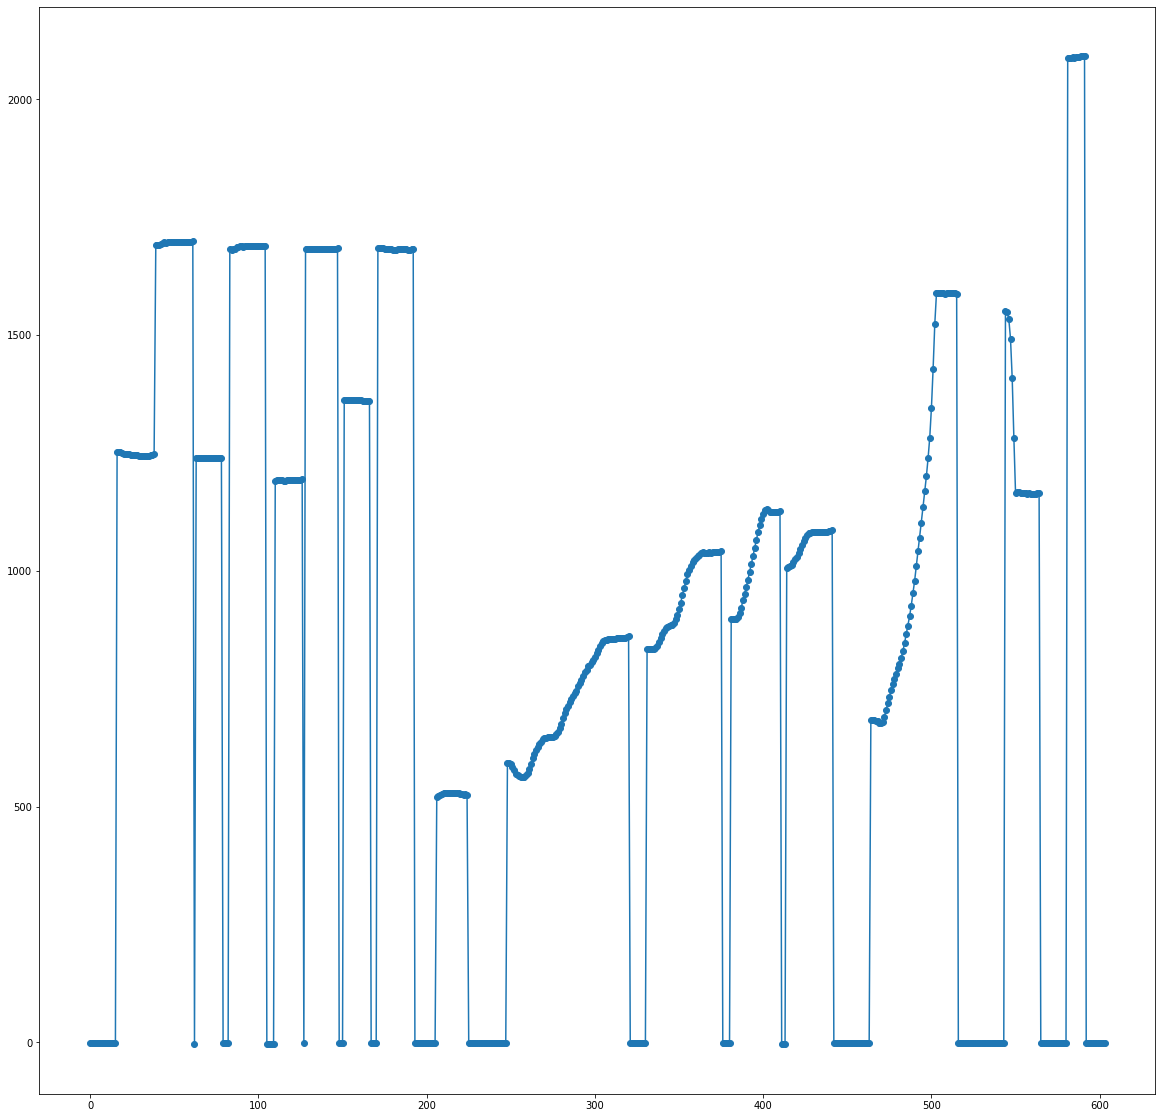

In [11]:
plt.plot(np_coords.sum(axis=1),'-o')
print(np_coords.shape)
print(len(np.where(np_coords.sum(axis=1) > 0)[0]))
print(len(np.where(np_coords.sum(axis=1) < 0)[0]))

In [17]:
# Machine Learning 이 아닌 Method 를 이용하여 영상을 Detection 해보기

# 읽은 동영상을 일괄 추론해서 좌표만 표시되는 MP4 로 기존과 같이 저장 + 좌표값을 array로 살려내기

import os
import random
import cv2
from tqdm import tqdm

# variables for time check
elapsed_cv = []

# variables for counting objects
obj_cnted_more_cv = []
obj_not_cnted_cv = []
obj_cnted_cv = []
obj_cnt_cv = 0
total_obj_cnt_cv = 0

# setting for Video input
# video_input = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_210119_3_Final_Demo.mp4'
# video_input = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_201217.mp4'
video_input = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_201222.mp4'
video_handle = cv2.VideoCapture(video_input)

# setting for Video output
video_output = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/inferencing_by_hough_3_720_1440_V30_201217.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 10.0, (720, 1440))

# check # of input video total frames
total_frm_cv = np.arange(int(video_handle.get(cv2.CAP_PROP_FRAME_COUNT)))

# variables for coordination records
coords_record_cv = []

# temp image list for show
test_img = []

for frm_cnt in tqdm(total_frm):
    if out.isOpened():
        ret, image_cv2 = video_handle.read()
        if ret:
#             image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
            start_time = time.time()
#             image_np = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2GRAY)
            image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2GRAY)
#             if (frm_cnt == 0):
#                 test_image = cv2.imread('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_original_image/images0100.jpg', cv2.IMREAD_COLOR)
#                 test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
#                 test_img = [test_image, image_cv2]
#                 plt.subplot(1, 2, 1), plt.title('original_image', color='WHITE', size=25), plt.imshow(test_img[0])
#                 plt.subplot(1, 2, 2), plt.title('captured_image', color='WHITE', size=25), plt.imshow(test_img[1])
                
            image_gray_blur = cv2.GaussianBlur(image_np, (3,3), 0)
            circles = cv2.HoughCircles(image_gray_blur, cv2.HOUGH_GRADIENT, 1, 100, param1=150, param2=40, minRadius=20, maxRadius=22) # original image marginal value
            end_time = time.time()
            elapsed_cv.append(end_time - start_time)

            plt.rcParams['figure.figsize'] = [20, 20]
            label_id_offset = 1
            image_np_with_detections = image_cv2.copy()
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            if circles is not None:
#                 print(circles.shape, len(circles[0]))
                for i in circles[0]:
                    cv2.circle(image_np_with_detections, (i[0], i[1]), int(i[2]), (255, 0, 0), 5)
            
                if (len(circles[0]) == 1):
                    coords_record_cv.append([circles[0][0][0], circles[0][0][1]])
                    obj_cnted_cv.append(frm_cnt)
                    obj_cnt = 1
                elif (len(circles[0]) > 1):
                    coords_record_cv.append([-1, -1])
                    obj_cnted_more_cv.append(frm_cnt)
                    obj_cnt = len(circles[0])
#                 print(frm_cnt)
#                 plt.imshow(image_np_with_detections)
#                 break
            else:
                coords_record_cv.append([-1, -1])
                obj_not_cnted_cv.append(frm_cnt)
                obj_cnt = 0
            
#             obj_cnt = 
#             obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.9)[0])
            total_obj_cnt_cv += obj_cnt    
            
#             if (frm_cnt == 49):
#                 print(circles)
#                 plt.imshow()
                

    
#             coordinates_y = [detections['detection_boxes'][0].numpy()[0][0], detections['detection_boxes'][0].numpy()[0][2]] * 1440
#             coordinates_x = [detections['detection_boxes'][0].numpy()[0][1], detections['detection_boxes'][0].numpy()[0][3]] * 720
#             final_coord = [round(sum(coordinates_y)/2), round(sum(coordinates_x)/2)]
#             final_coord = list(map(int, final_coord))
#             if obj_cnt == 1:
#                 coords_record_cv.append(final_coord)
#                 obj_cnted_cv.append(frm_cnt)
#             elif obj_cnt > 1:
#                 coords_record_cv.append([-2,-2])
#                 obj_cnted_more_cv.append(frm_cnt)
#             else : #obj_cnt == 0
#                 coords_record_cv.append([-1,-1])
#                 obj_not_cnted_cv.append(frm_cnt)
            
            cv2.putText(image_np_with_detections, 'Frames {0:1d}'.format(frm_cnt+1), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Counted {0:1d}'.format(len(obj_cnted_cv)), (180,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'noCount {0:1d}'.format(len(obj_not_cnted_cv)), (20,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Dbl Cnt {0:1d}'.format(len(obj_cnted_more_cv)), (180,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            
#             # Just for test
#             image_np_with_detections[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440), max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 0:2] = 0
#             image_np_with_detections[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440), max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 2] = 255
            
#             out.write(image_np_with_detections)
        
out.release()

mean_elapsed = sum(elapsed_cv) / float(len(elapsed_cv))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image / ' + str(sum(elapsed)) + ' for total')
print('Total frm cnt : ', frm_cnt + 1)
print('obj_cnted : ', len(obj_cnted_cv))
# print(obj_cnted)
print('obj_not_cnted : ', len(obj_not_cnted_cv))
# print(obj_not_cnted)
print('obj_cnt_more : ', len(obj_cnted_more_cv))
# print(obj_cnted_more)

# print(coords_record)


100%|██████████| 604/604 [00:08<00:00, 67.27it/s]

Elapsed time: 0.01217617222804897 second per image / 8.59762716293335 for total
Total frm cnt :  604
obj_cnted :  333
obj_not_cnted :  258
obj_cnt_more :  13


In [18]:
np_coords_cv = np.array(coords_record_cv, dtype=int)
print(np_coords_cv.shape)
print(np_coords_cv)

(604, 2)
[[150 807]
 [ -1  -1]
 [ -1  -1]
 ...
 [ -1  -1]
 [ -1  -1]
 [ -1  -1]]


(604, 2)
438
166


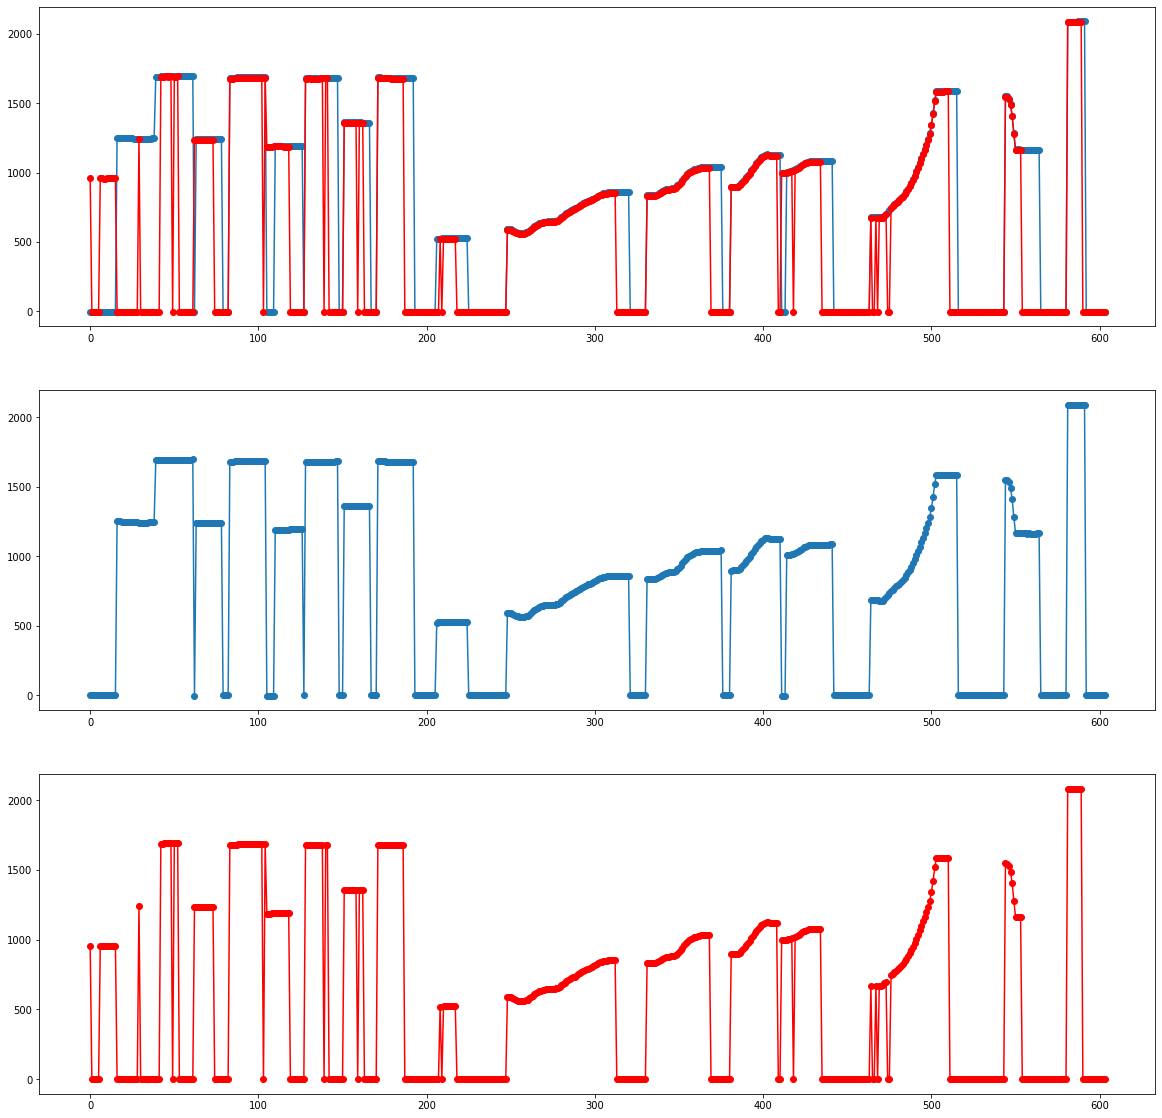

In [22]:
plt.subplot(311)
# plt.axis('off')
plt.plot(np_coords.sum(axis=1),'-o')
plt.plot(np_coords_cv.sum(axis=1), '-or')
plt.subplot(312)
# plt.axis('off')
plt.plot(np_coords.sum(axis=1),'-o')
plt.subplot(313)
# plt.axis('off')
plt.plot(np_coords_cv.sum(axis=1), '-or')
print(np_coords.shape)
print(len(np.where(np_coords.sum(axis=1) > 0)[0]))
print(len(np.where(np_coords.sum(axis=1) < 0)[0]))

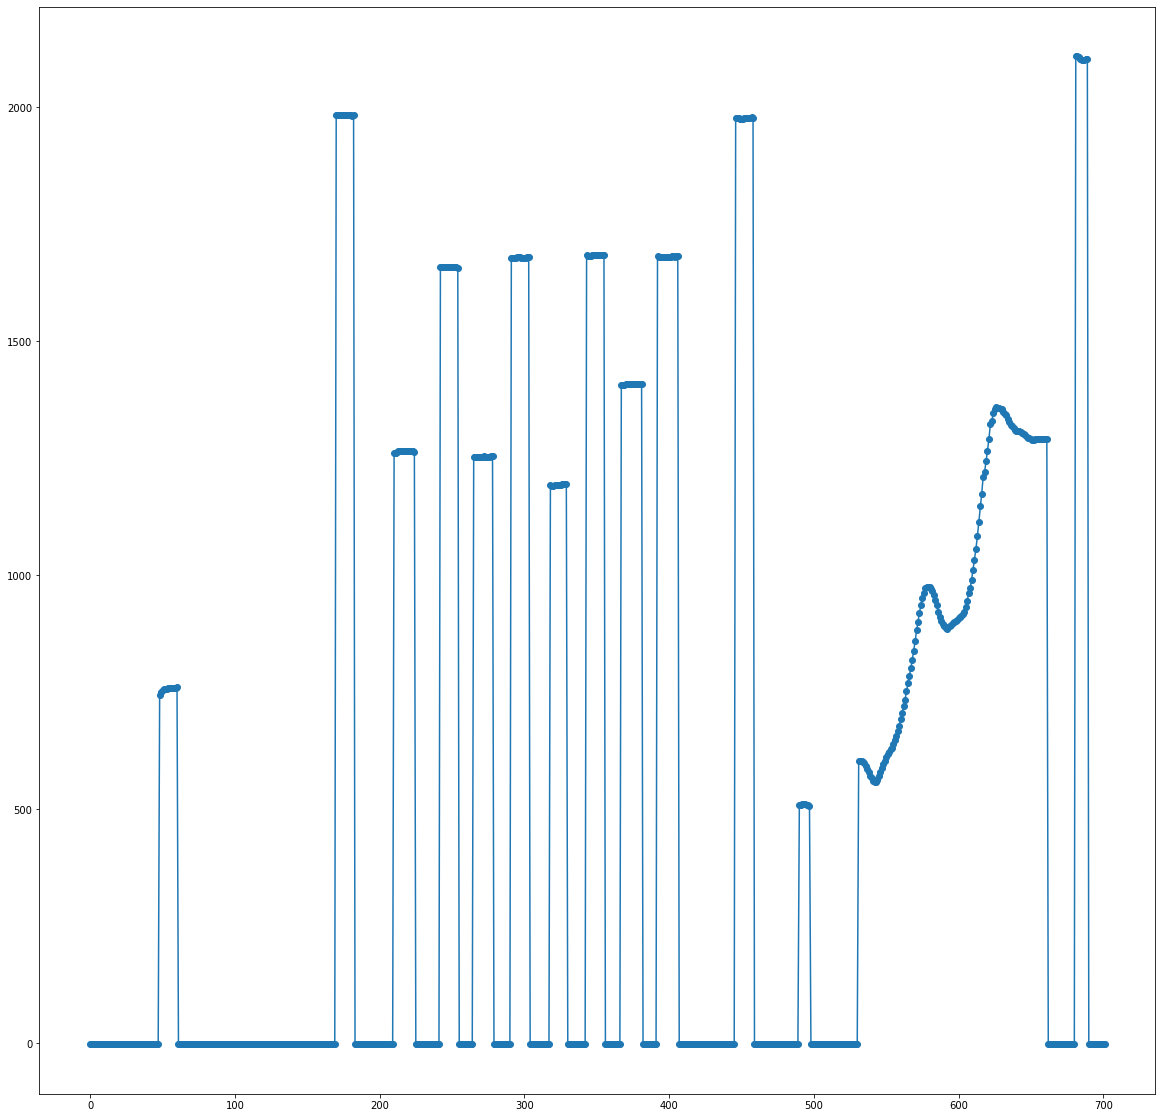

In [49]:
plt.plot(np_coords.sum(axis=1),'-o')

In [21]:
#새로운 Detect State 와 그에 따른 좌표 Logging을 다시 해보자

# 읽은 동영상을 일괄 추론해서 좌표만 표시되는 MP4 로 기존과 같이 저장 + 좌표값을 array로 살려내기

import os
import random
import cv2
from tqdm import tqdm

# variables for time check
elapsed = []

# variables for counting objects
obj_cnted_more = []
obj_not_cnted = []
obj_cnt = 0
total_obj_cnt = 0

# setting for Video input
# video_input = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_201229.mp4'
video_input = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_210119_3_Final_Demo.mp4'
video_handle = cv2.VideoCapture(video_input)

# setting for Video output
video_output = '/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/720_1440_V30_210119_3_Final_Demo_output_th90.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 10.0, (720, 1440))

# check # of input video total frames
total_frm = np.arange(int(video_handle.get(cv2.CAP_PROP_FRAME_COUNT)))

# Additional output frame to append to inferenced image
coordination_img = np.ones((1440, 720, 3))

# variables for coordination records
coords_record_new = np.empty((0, 2), int)

# states and state_cnt for detection for frames
states = []
state_idx = 0
state_cnt = 0
state_swt_cnt = 0

for frm_cnt in tqdm(total_frm):
    if out.isOpened():
        ret, image_cv2 = video_handle.read()
        if ret:
            if state_idx == 0:
                state_cnt += 1
                if state_cnt % 5 :
                    continue
                else :
                    state_cnt = 0
                    
            elif state_idx == 2:
                state_cnt += 1
                if state_cnt % 2 : 
                    continue
                else :
                    state_cnt = 0
                             
            image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
            input_tensor = np.expand_dims(image_np, 0)

            start_time = time.time()
            detections = detect_fn(input_tensor)
            end_time = time.time()
            elapsed.append(end_time - start_time)

            plt.rcParams['figure.figsize'] = [20, 20]
            label_id_offset = 1
            image_np_with_detections = image_cv2.copy()
            viz_utils.visualize_boxes_and_labels_on_image_array(
                  image_np_with_detections,
                  detections['detection_boxes'][0].numpy(),
                  detections['detection_classes'][0].numpy().astype(np.int32),
                  detections['detection_scores'][0].numpy(),
                  category_index,
                  use_normalized_coordinates=True,
                  max_boxes_to_draw=200,
                  min_score_thresh=.90,
                  agnostic_mode=False)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.9)[0])
            total_obj_cnt += obj_cnt
    
#             if obj_cnt == 0 :
#                 obj_not_cnted.append(frm_cnt)
#                 cv2.imwrite('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/' + 'noobj_images{0:04d}.jpg'.format(frm_cnt), image_np_with_detections)
# #                 print('No Count!!')
#             elif obj_cnt > 1:
#                 obj_cnted_more.append(frm_cnt)
#                 cv2.imwrite('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/' + 'dbl_images{0:04d}.jpg'.format(frm_cnt), image_np_with_detections)
# #                 print('Count more then 2!!')

            coordinates_y = [detections['detection_boxes'][0].numpy()[0][0], detections['detection_boxes'][0].numpy()[0][2]] * 1440
            coordinates_x = [detections['detection_boxes'][0].numpy()[0][1], detections['detection_boxes'][0].numpy()[0][3]] * 720
            final_coord = [round(sum(coordinates_y)/2), round(sum(coordinates_x)/2)]
            final_coord = list(map(int, final_coord))
            if obj_cnt == 1:
                coords_record_new = np.append(coords_record_new, np.array([final_coord]), axis=0)
#                 coords_record_new.append(final_coord)
            elif obj_cnt > 1:
                coords_record_new = np.append(coords_record_new, np.array([[-2, -2]]), axis=0)
#                 coords_record_new.append([-2,-2])
            else : #obj_cnt == 0
#                 print(frm_cnt, coords_record_new)
                coords_record_new = np.append(coords_record_new, np.array([[-1, -1]]), axis=0)
#                 coords_record_new.append([-1,-1])
            
            coordination_img = np.ones((1440, 720, 3))
            coordination_img[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440),max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 0:2] = 0
            coordination_img[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440),max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 2] = 255

            cv2.putText(image_np_with_detections, 'Counted {0:1d}'.format(total_obj_cnt), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'noCount {0:1d}'.format(len(obj_not_cnted)), (180,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            cv2.putText(image_np_with_detections, 'Dbl Cnt {0:1d}'.format(len(obj_cnted_more)), (20,50), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
            
            # Just for test
            image_np_with_detections[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440), max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 0:2] = 0
            image_np_with_detections[max(final_coord[0]-5, 0):min(final_coord[0]+5, 1440), max(final_coord[1]-5, 0):min(final_coord[1]+5, 720), 2] = 255
            
            # If pressed 
#             print(coords_record_new[-1].sum())
            if coords_record_new[-1].sum() > 0: 
                if state_idx == 0:
                    state_idx = 1
                    state_cnt = 0
                elif state_idx == 1:
                    state_swt_cnt += 1
                    if state_swt_cnt == 3:
                        state_idx = 2
                        state_swt_cnt = 0
                        state_cnt = 0
                
            # else if released
            elif coords_record_new[-1].sum() == -2:
                if state_idx != 0:
                    state_idx = max(0, (state_idx - 1)) % 3
                    state_cnt = 0
                
            # Save state information 
            states.append([state_idx, state_cnt, state_swt_cnt])
#             if frm_cnt == 0:
# #                 print(image_np_with_detections)
# #                 print(image_np_with_detections.max())
#                 image_np_with_detections = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)
#                 plt.imshow(image_np_with_detections)
#                 break
            
#             out.write(image_np_with_detections)
        
out.release()

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image / ' + str(sum(elapsed)) + ' for total')


print('Total frame cnt : ', frm_cnt+1)
print('Coordination cnt : ', len(coords_record_new))


# print(coords_record)


100%|██████████| 702/702 [00:07<00:00, 94.55it/s] 

Elapsed time: 0.01788949684833917 second per image / 4.543932199478149 for total
Total frame cnt :  702
Coordination cnt :  254


In [22]:
np_coords = np.array(coords_record_new)
# print(np_coords)
# print(np.where(np_coords[:, 0] > 0))

# multiply it for its resolution in device
print('before \n', np_coords[np.where(np_coords[:, 0] > 0)])
np_coords[np.where(np_coords[:, 0] > 0)] *= 2

print('after \n', np_coords[np.where(np_coords[:, 0] > 0)])
        


before 
 [[ 382  368]
 [ 385  370]
 [ 386  372]
 [ 386  372]
 [ 387  373]
 [ 387  373]
 [ 387  373]
 [ 389  372]
 [1295  687]
 [1296  686]
 [1296  686]
 [1296  686]
 [1296  686]
 [1296  686]
 [1296  686]
 [1006  256]
 [1006  256]
 [1006  257]
 [1008  257]
 [1009  257]
 [1009  257]
 [1009  257]
 [1009  257]
 [1009  256]
 [1084  575]
 [1084  575]
 [1084  575]
 [1084  575]
 [1084  574]
 [1084  574]
 [1103  150]
 [1103  150]
 [1102  150]
 [1102  150]
 [1103  150]
 [1103  150]
 [1102  150]
 [1103  151]
 [1098  581]
 [1098  581]
 [1098  581]
 [1098  580]
 [1098  580]
 [1099  580]
 [ 991  200]
 [ 991  201]
 [ 991  201]
 [ 991  201]
 [ 991  202]
 [ 992  202]
 [ 992  202]
 [1096  587]
 [1096  587]
 [1096  587]
 [1096  587]
 [1096  587]
 [1097  588]
 [1111  296]
 [1110  296]
 [1111  295]
 [1112  296]
 [1112  297]
 [1112  297]
 [1112  297]
 [1112  297]
 [1112  297]
 [1100  580]
 [1100  580]
 [1101  578]
 [1101  578]
 [1101  578]
 [1101  579]
 [1102  579]
 [1102  578]
 [1103  578]
 [1309  666]
 [1

(254, 2)
158
96
[772 744]


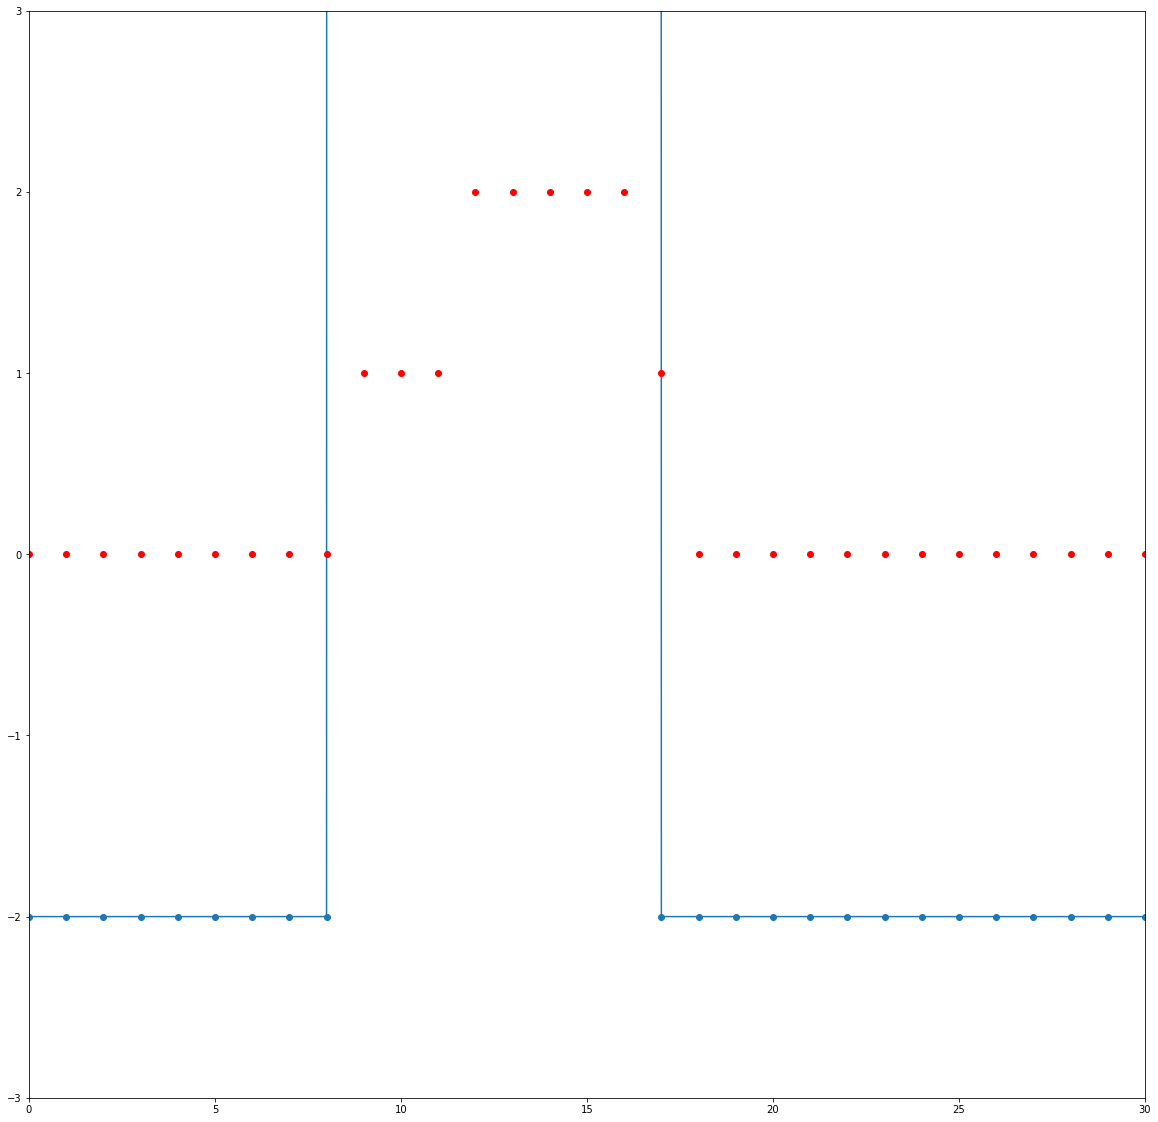

In [24]:
plt.xlim(0, 30)
plt.ylim(-3, 3)
plt.plot(np_coords.sum(axis=1),'-o')
print(np_coords.shape)
print(len(np.where(np_coords.sum(axis=1) > 0)[0]))
print(len(np.where(np_coords.sum(axis=1) < 0)[0]))
plt.plot(np.array(states)[:,0], 'ro')
print(np_coords[12])

[0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 2 2 2 2 1 0 0 0 0 0 1 1 1 2 2 2 2 2 2 1 0 0 0 0 1 1 1 2 2 2 1
 0 0 1 1 1 2 2 2 2 2 1 0 0 0 1 1 1 2 2 2 1 0 0 0 1 1 1 2 2 2 2 1 0 0 0 1 1
 1 2 2 2 1 0 0 1 1 1 2 2 2 2 2 2 1 0 0 1 1 1 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0
 1 1 1 2 2 2 2 1 0 0 0 0 0 0 1 1 1 2 2 1 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 0 0 0 1 1 1 2 2 1 0 0]
254


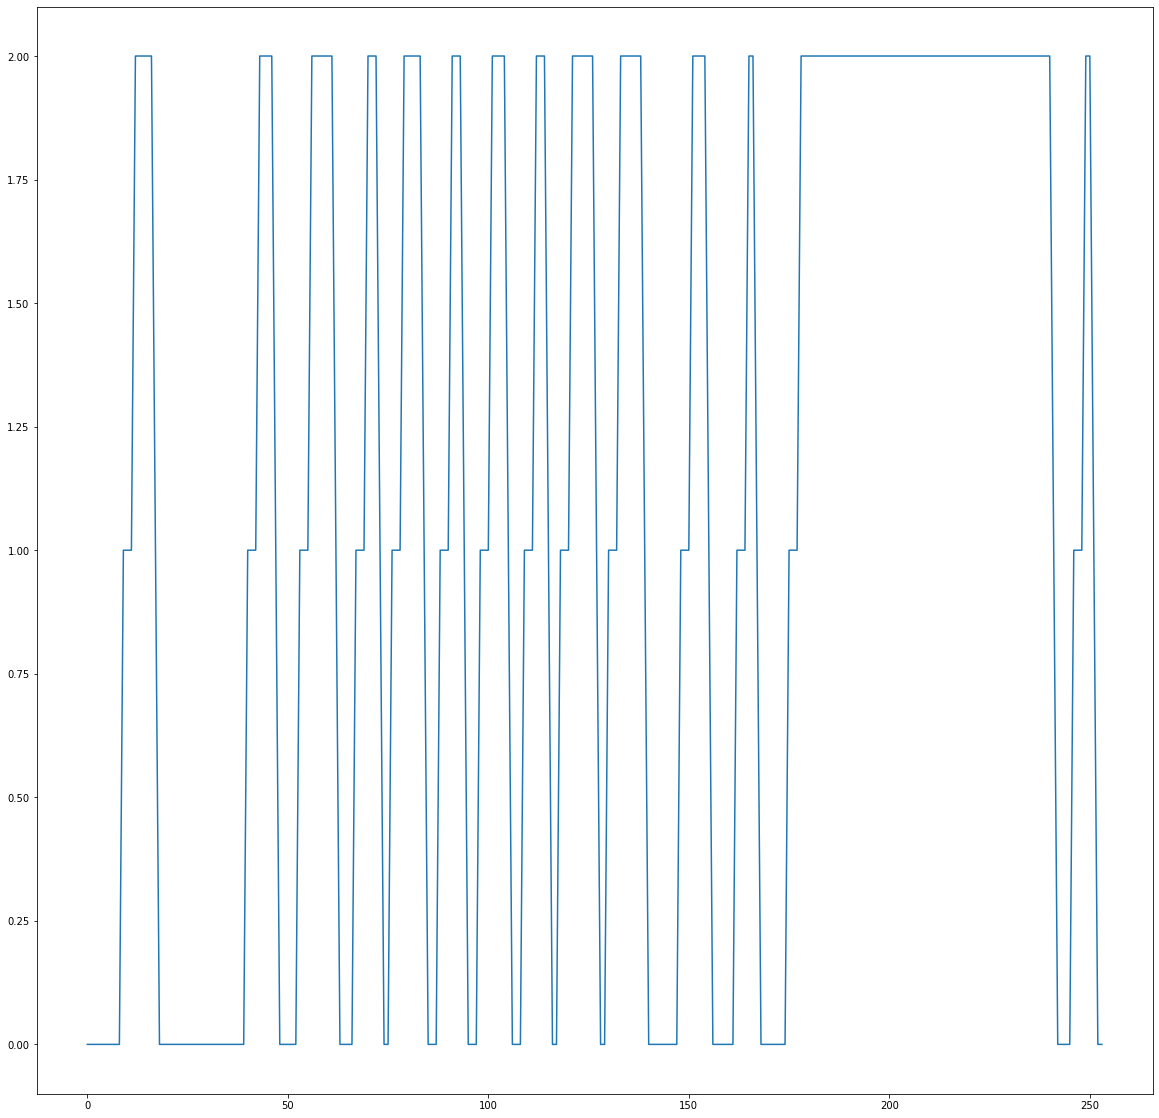

In [33]:

# for st, cnt, st_cnt in states:
#     print(st, cnt, st_cnt)

print(np.array(states)[:,0])
print(len(states))
plt.plot(np.array(states)[:,0])


In [23]:

print(np_coords[150:152])
print(np_coords[150]**2 - np_coords[152]**2)
print(np.sqrt((np_coords[150] - np_coords[151])**2).sum())

[[2214 1154]
 [2216 1152]]
[-8860  9216]
4.0


In [34]:

sleep_cnt = 0
st_in_2_frm = []

with open('/home/yousungchoi/projects/project_coordination/workspace/training_demo/images/inference_video/test_script_demo.txt', 'w') as f:
    data = 'type= user\n'
    f.write(data)
    data = 'speed= 1000\n'
    f.write(data)
    data = 'start data >>\n\n'
    f.write(data)
    
    for i, val in enumerate(np.array(states)[:,0]):
        st_in_2_frm = [np.array(states)[:,0][i-1], np.array(states)[:,0][i]] if i > 0 else [np.array(states)[:,0][i], np.array(states)[:,0][i]]
#         print(st_in_2_frm)

        
        if st_in_2_frm[1] == 0:
            sleep_cnt += 16 * 5
        elif st_in_2_frm[1] == 2:
            sleep_cnt += 16 * 2
            # Drag
            if st_in_2_frm[0] == 2:
                coords_diff = np.sqrt((np_coords[i] - np_coords[i-1])**2).sum()
                if coords_diff > 20:
                    data = 'UserWait(%d)\n' %sleep_cnt
                    f.write(data)
                    data = 'DispatchPointer(0, 0, 2, %d, %d, 0, 0, 0, 0, 0, 0, 0)\n' %(np_coords[i][1], np_coords[i][0])
                    f.write(data)
                    sleep_cnt = 0
                
        # state switch occur (press or release)
        elif st_in_2_frm[1] == 1:
            # Release
            if st_in_2_frm[0] == 0:
                data = 'UserWait(%d)\n' %sleep_cnt
                f.write(data)
                data = 'DispatchPointer(0, 0, 0, %d, %d, 0, 0, 0, 0, 0, 0, 0)\n' %(np_coords[i][1], np_coords[i][0])
                f.write(data)
                sleep_cnt = 0
                
            # Press
            elif st_in_2_frm[0] == 2:
                data = 'UserWait(%d)\n' %sleep_cnt
                f.write(data)
                data = 'DispatchPointer(0, 0, 1, %d, %d, 0, 0, 0, 0, 0, 0, 0)\n' %(np_coords[i-2][1], np_coords[i-2][0])
                f.write(data)
                sleep_cnt = 0
                
            
            
            